In [1]:
import numpy as np, numpy.random
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from tqdm import tqdm

In [2]:
def set_seed(random_seed):
#     random.seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.backends.cudnn.benckmark = False
    torch.backends.cudnn.deterministic = True
    torch.set_default_dtype(torch.float32)
    
set_seed(2024)

In [3]:
# Check CUDA
 
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"CUDA version: {torch.version.cuda}")
 
# Storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"ID of current CUDA device: {torch.cuda.current_device()}")
       
print(f"Name of current CUDA device: {torch.cuda.get_device_name(cuda_id)}")

Is CUDA supported by this system? True
CUDA version: 11.8
ID of current CUDA device: 0
Name of current CUDA device: Quadro M1000M


In [4]:
csvFile = pd.read_csv('Dataset/structure4.csv')
df_parameter = csvFile.iloc[:, :10]

df_SE = csvFile.iloc[:, 10:11]
df_Tvis = csvFile.iloc[:, 12:13] * 100
df_metric = pd.concat([df_Tvis, df_SE], axis=1)

df_parameter.head()

,parameter-bott,parameter-cbbotr,parameter-cbheight,parameter-cbotr,parameter-cbtopr,parameter-cheight,parameter-ctopr,parameter-pitch,parameter-silvert,parameter-topt
0,95.718148,43.354505,216.598869,60.874317,131.467336,167.252109,34.541709,327.772442,5.402554,78.748219
1,57.192794,68.338471,146.439212,123.218142,92.990379,660.143754,110.076490,384.452082,13.987269,43.500956
2,48.759242,66.320557,946.568699,165.201964,79.994531,490.872671,78.274344,338.646017,3.293220,71.431971
3,76.378067,7.885207,79.406897,91.347128,108.114417,282.759484,31.222274,343.268350,15.507130,77.861851
4,42.933965,13.041809,608.350193,165.886507,168.164578,12.599300,49.941049,362.320432,14.774567,71.680716


In [5]:
max_values_parameter = df_parameter.max()
max_values_parameter

parameter-bott         100.0
parameter-cbbotr       200.0
parameter-cbheight    1000.0
parameter-cbotr        200.0
parameter-cbtopr       200.0
parameter-cheight     1000.0
parameter-ctopr        200.0
parameter-pitch        400.0
parameter-silvert       20.0
parameter-topt         100.0
dtype: float64

In [6]:
# Normalization Parameters
df_parameter_norm = df_parameter / max_values_parameter
df_parameter_norm.head()

,parameter-bott,parameter-cbbotr,parameter-cbheight,parameter-cbotr,parameter-cbtopr,parameter-cheight,parameter-ctopr,parameter-pitch,parameter-silvert,parameter-topt
0,0.957181,0.216773,0.216599,0.304372,0.657337,0.167252,0.172709,0.819431,0.270128,0.787482
1,0.571928,0.341692,0.146439,0.616091,0.464952,0.660144,0.550382,0.961130,0.699363,0.435010
2,0.487592,0.331603,0.946569,0.826010,0.399973,0.490873,0.391372,0.846615,0.164661,0.714320
3,0.763781,0.039426,0.079407,0.456736,0.540572,0.282759,0.156111,0.858171,0.775356,0.778619
4,0.429340,0.065209,0.608350,0.829433,0.840823,0.012599,0.249705,0.905801,0.738728,0.716807


In [15]:
max_values_metric = df_metric.max()
max_values_metric

value-Transmission    98.0440
value-EMI_SE          47.5501
dtype: float64

<function matplotlib.pyplot.show(close=None, block=None)>

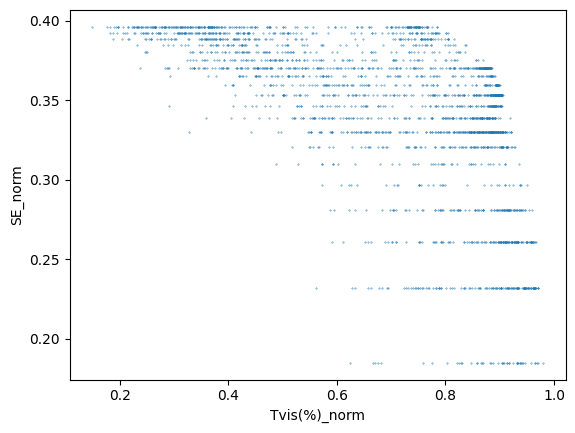

In [16]:
# Normalization Metrics (Tested: No Difference)

SE_max = 120
Tvis_max = 100

df_SE_norm = df_SE / SE_max
df_Tvis_norm = df_Tvis / Tvis_max
df_metric_norm = pd.concat([df_Tvis_norm, df_SE_norm], axis=1)

plt.scatter(df_Tvis_norm, df_SE_norm, s=0.1)
plt.xlabel("Tvis(%)_norm")
plt.ylabel("SE_norm")
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

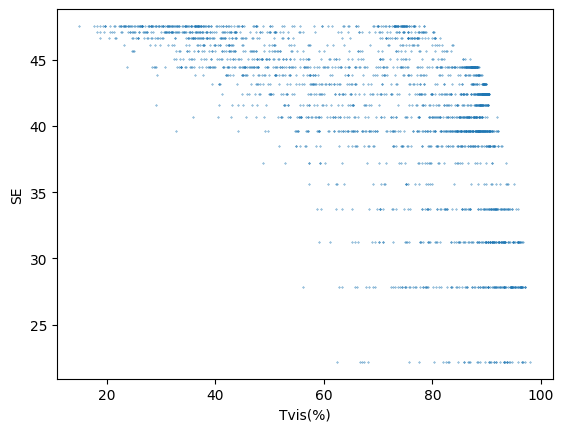

In [9]:
plt.scatter(df_Tvis, df_SE, s=0.1)
plt.xlabel("Tvis(%)")
plt.ylabel("SE")
plt.show

Dataset for Reward Model, $\forall x$: function $r_\theta : \mathcal{Y} \mapsto z$

$x$: 2d vector sum to 1

$y_i, y_j$: indicate by index

$z_{y_i, y_j | x}$: preference output

Data for Pretrained Base Pareto Model: function $f_\theta : \mathcal{X} \mapsto \mathcal{Y}$

this can be trained naively: choose the best completion $y_i$ under the most weighted metric(s)

In [17]:
# Generate Dataset for Reward Model and Pretrained Base Pareto Model
parameter_mat = df_parameter_norm.to_numpy()
metric_mat = df_metric_norm.to_numpy()

dim_x = 2
dim_y = len(df_parameter_norm.columns)
x_n = 100
y_n = len(df_parameter_norm)

Xset = []
Yset = []
Zset = []
Mset = []
Rset = []

for i in tqdm(range(x_n)):
    x = np.array(([i/x_n, 1-i/x_n]))
    Xset.append(x.flatten())
    value_x = np.dot(metric_mat, x.T)

    index_sorted = sorted(range(len(value_x)), key=lambda k: value_x[k])
    Yset.append(parameter_mat[index_sorted[-1]])
    Mset.append(metric_mat[index_sorted[-1]])

    
    # Reward Dataset Design
    Rset.append(np.array([value_x]).T)
        
#     z_mat = [[0 for i in range(y_n)] for j in range(y_n)]
    
#     for j in range(y_n):
#         z_mat[index_sorted[j]][index_sorted[j]] = np.random.binomial(1, 0.5, 1)
#         for k in range(1, y_n - j):
#             z_mat[index_sorted[j]][index_sorted[k]] = 1
#             z_mat[index_sorted[k]][index_sorted[j]] = 0
            
#     Zset.append(z_mat)


100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 1128.58it/s]


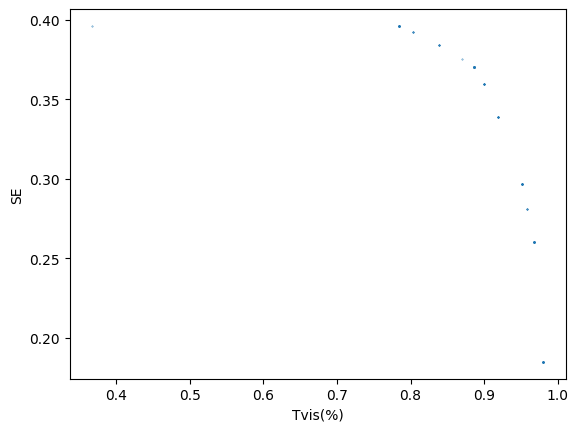

In [18]:
# Pareto from Data for Pretrain base model

plt.scatter([Mset[i][0] for i in range(x_n)], [Mset[i][1] for i in range(x_n)], s=0.1)
plt.xlabel("Tvis(%)")
plt.ylabel("SE")
plt.show()

In [ ]:
# Pretrain base model should return a parameterized distribution of Pareto (policy network)



100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1092.06it/s]


Predicted Output: tensor([[ 45.7867,  52.2498,  77.8926,  22.8041,  49.1946, 141.7164,  12.6815,
         329.5996,  12.0091,  46.2767]])


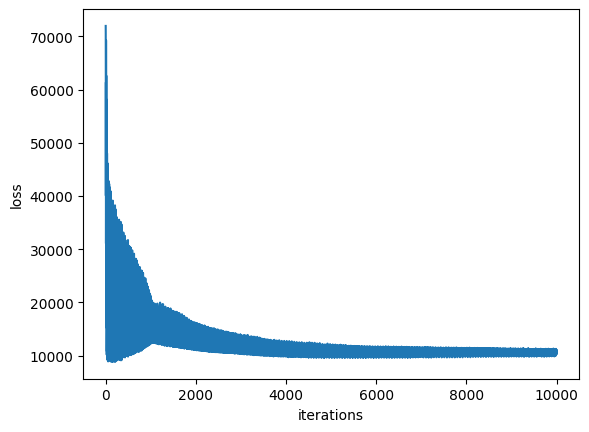

In [12]:
# # Pretrain base model of Pareto
# class TwoToTenNet(nn.Module):
#     def __init__(self, state_dim, action_dim, hidden_size=64):
#         super(TwoToTenNet, self).__init__()
#         self.fc1 = nn.Linear(state_dim, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, action_dim)

#     def forward(self, state):
#         state = torch.relu(self.fc1(state))  # ReLU activation for the first layer
#         state = self.fc2(state)  # Output layer without activation function
#         return state

# Xset_tensor = torch.from_numpy(np.array(Xset)).to(torch.float32)
# Yset_tensor = torch.from_numpy(np.array(Yset)).to(torch.float32)
    
# # Training data
# input_data = Xset_tensor 
# target_data = Yset_tensor 

# # Create the model
# model = TwoToTenNet(dim_x, dim_y)

# # Define the loss functioy_n and optimizer
# criterion = nn.MSELoss()
# optimizer = optim.SGD(model.parameters(), lr=0.01)

# # Training loop
# ll = []
# num_epochs = 10000
# for epoch in tqdm(range(num_epochs)):
#     # Forward pass
#     outputs = model(input_data)
    
#     # Compute the loss
#     loss = criterion(outputs, target_data)
    
#     # Backward pass and optimization
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     ll.append(loss.item())

# plt.plot(ll)
# plt.xlabel("iterations")
# plt.ylabel("loss")
# plt.show

# # Testing the model
# test_input = torch.tensor([[0.5, 0.5]])  # Example input
# with torch.no_grad():
#     predicted_output = model(test_input)
#     print("Predicted Output:", predicted_output)
    
# PretrainModel = model

In [13]:
# Pretrain base model of Pareto
Pset = []
df_Pset = pd.DataFrame()

for i in tqdm(range(x_n)):
    with torch.no_grad():
        predicted_output = PretrainModel(torch.tensor([[i/x_n, 1-i/x_n]])).numpy()
        Pset.append(predicted_output)
        df_Pset = pd.concat([df_Pset, pd.DataFrame(predicted_output)], ignore_index=True)

df_Pset.columns = df_parameter.columns
df_Pset

100%|██████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 2662.10it/s]


,parameter-bott,parameter-cbbotr,parameter-cbheight,parameter-cbotr,parameter-cbtopr,parameter-cheight,parameter-ctopr,parameter-pitch,parameter-silvert,parameter-topt
0,56.483536,35.766060,-141.183640,63.608124,115.328278,37.584320,28.556543,391.990173,26.162649,56.493931
1,56.222137,36.265919,-139.314529,61.919029,113.409492,37.646301,28.143822,391.546326,25.832010,56.164684
2,55.960747,36.765759,-137.445419,60.229927,111.490707,37.708344,27.731104,391.102478,25.501373,55.835445
3,55.699348,37.265617,-135.576340,58.540810,109.571922,37.770325,27.318382,390.658691,25.170734,55.506195
4,55.437958,37.765469,-133.707291,56.851685,107.653137,37.832275,26.905657,390.214844,24.840096,55.176952
...,...,...,...,...,...,...,...,...,...,...
95,35.753071,31.258144,1019.773804,79.454483,89.083542,788.135132,39.072315,252.879028,2.775412,37.765652
96,35.850868,31.149975,1039.529785,80.318542,90.210846,798.451416,40.059299,255.298981,2.676074,37.766815
97,35.948654,31.041803,1059.285645,81.182594,91.338150,808.767456,41.046291,257.718964,2.576736,37.767971
98,36.046448,30.933636,1079.041382,82.046638,92.465446,819.083740,42.033272,260.138916,2.477398,37.769135


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]


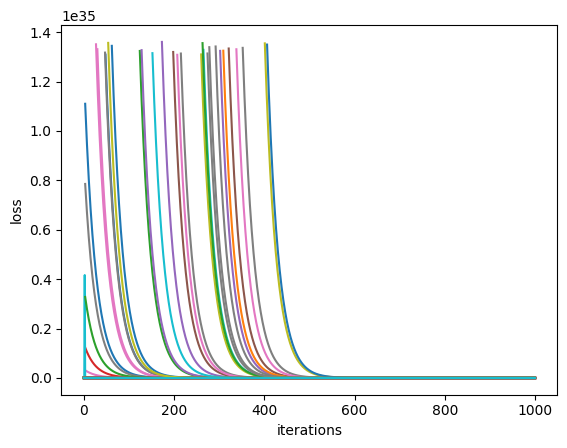

In [14]:
# Reward Model can not be seperated by direction: only train an global reward model

# class RewardNet(nn.Module):
#     def __init__(self):
#         super(RewardNet, self).__init__()
#         self.fc1 = nn.Linear(10, 64)  # Input layer: 10 features, Output layer: 64 neurons
#         self.fc2 = nn.Linear(64, 1)  # Hidden layer: 64 neurons, Output layer: 1 neurons

#     def forward(self, x):
#         x = torch.relu(self.fc1(x))  # ReLU activation for the first layer
#         x = self.fc2(x)  # Output layer without activation function
#         return x

    
# RewardModels = []
# for i in tqdm(range(x_n)):
#     flag = True
    
#     parameter_tensor = torch.from_numpy(parameter_mat).to(torch.float32)
#     Rset_tensor = torch.from_numpy(Rset[i]).to(torch.float32)
    
#     while(flag):
#         # Training data
#         input_data = parameter_tensor  # 2500 samples, 10 input features
#         target_data = Rset_tensor  # 2500 samples, 1 target features

#         # Create the model
#         model = RewardNet()

#         # Define the loss function and optimizer
#         criterion = nn.MSELoss()
#         optimizer = optim.SGD(model.parameters(), lr=0.01)

#         # Training loop
#         ll = []
#         num_epochs = 1000
#         for epoch in range(num_epochs):
#             # Forward pass
#             outputs = model(input_data)

#             # Compute the loss
#             loss = criterion(outputs, target_data)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#             ll.append(loss.item())

#         with torch.no_grad():
#             predicted_output = model(torch.tensor(Pset[i]))
#             flag = torch.isnan(predicted_output)
    
#     plt.plot(ll)
#     plt.xlabel("iterations")
#     plt.ylabel("loss")
#     plt.show

#     RewardModels.append(model)


In [24]:
df = pd.DataFrame(Yset)
pareto = df.drop_duplicates()
pareto

,0,1,2,3,4,5,6,7,8,9
0,0.594180,0.280932,0.118068,0.000000,0.280933,0.805912,0.000000,1.000000,0.952808,0.799161
1,0.382632,0.085470,0.000000,0.371937,0.543686,0.000000,0.111644,0.670137,0.978834,0.383307
16,0.405229,0.000000,0.000000,0.339325,0.141856,0.000000,0.336451,0.431599,0.926375,0.443343
19,0.461142,0.000000,0.000000,0.000000,0.243916,0.982328,0.000000,0.274181,0.832059,0.418260
23,0.396895,0.678163,0.011360,0.340907,0.678163,0.002363,0.340902,0.678163,0.718477,0.387918
24,0.438451,0.263247,0.001011,0.034789,0.264288,0.000000,0.034350,0.999869,0.655699,0.430696
45,0.440697,0.160530,0.000215,0.125721,0.212590,0.000008,0.125721,0.720895,0.551544,0.431949
51,0.398074,0.181350,0.564298,0.317873,0.190176,0.429864,0.059747,0.368795,0.402832,0.410934
57,0.354893,0.320745,0.486336,0.366915,0.379006,0.907253,0.074305,0.414787,0.245737,0.477764
68,0.481851,0.168749,0.437472,0.323769,0.343140,0.419987,0.003521,0.361243,0.177451,0.414184
